In [3]:
### load libraries ###
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import re # data preprocessing, removing punctuation

import matplotlib.pyplot as plt # EDA, visualization
import seaborn as sns # EDA, visualization
from wordcloud import WordCloud # EDA, word cloud visualization

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer # data preprocessing, matrix vectorization
from sklearn.decomposition import NMF # modeling, unsupervised classification
from sklearn.naive_bayes import MultinomialNB # modeling, classified model
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix # model evaluation

In [4]:
### import datasets ###

train_file = '/kaggle/input/bbc-news-classification/BBC News Train.csv'
test_file = '/kaggle/input/bbc-news-classification/BBC News Test.csv'

df_train = pd.read_csv(train_file)
df_test = pd.read_csv(test_file)

In [5]:
# check data types
df_train.info()
df_test.info()

# show data frames
print(df_train.head(10))
print(df_test.head(10))

# understand category distribution
print(df_train['Category'].value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1490 entries, 0 to 1489
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  1490 non-null   int64 
 1   Text       1490 non-null   object
 2   Category   1490 non-null   object
dtypes: int64(1), object(2)
memory usage: 35.1+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 735 entries, 0 to 734
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  735 non-null    int64 
 1   Text       735 non-null    object
dtypes: int64(1), object(1)
memory usage: 11.6+ KB
   ArticleId                                               Text       Category
0       1833  worldcom ex-boss launches defence lawyers defe...       business
1        154  german business confidence slides german busin...       business
2       1101  bbc poll indicates economic gloom citizens in ...       business
3       1976  lifesty

In [6]:
print("-" * 50)
print("STEP 1: Problem & Data Description")
print("-" * 50)

--------------------------------------------------
STEP 1: Problem & Data Description
--------------------------------------------------


**Problem**: The original Kaggle competition task for this dataset was to employ both supervised and unsupervised classification methods to predict the category of an article based on its text. For my final assignments, I will:
* **Supervised Classification**: Try to improve the performance of my supervised classification model by (1) pre-processing to include N-grams and (2) trying other supervised classification methods, including SVM and logistic regression.

**Data Description**: Include are a testing dataset and a training dataset. The features included in these datasets are:
* **ArticleId**: int64, unique identifier for unique articles
* **Text**: string, article source text
* **Category**: object; classification of article; one of five: sport, business, politics, entertainment, tech (only in the training dataset, not the testing dataset)

In [7]:
print("-" * 50)
print("STEP 2a: EDA - Cleaning and Pre-processing")
print("-" * 50)

--------------------------------------------------
STEP 2a: EDA - Cleaning and Pre-processing
--------------------------------------------------


In [8]:
### Data Cleaning and Preprocessing: Lowercasing & Punctuation Removal ###
# For text vectorization, preprocessing should include setting all words in lowercase; removing punctuation; removing articles and prepositions ("stop words"); tokenization; and stemming.

# set words in lowercase
df_train['Text'] = df_train['Text'].str.lower()
df_test['Text'] = df_test['Text'].str.lower()

# remove punctation
def remove_punctuation(text):
    text = re.sub(r'a-z\s0-9\$', '', text) # retain a-z, 0-9, white spaces, and '$'
    return text

df_train['Text'] = df_train['Text'].apply(remove_punctuation)
df_test['Text'] = df_test['Text'].apply(remove_punctuation)

In [9]:
### Data Cleaning and Preprocessing: Stop Word Removal ###
# create function to remove stop words
# network issues when trying to download nltk stopwords, creating list
STOPWORDS = set([
    'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your', 'yours', 
    'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', 'her', 'hers', 
    'herself', 'it', 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 
    'what', 'which', 'who', 'whom', 'this', 'that', 'these', 'those', 'am', 'is', 'are', 
    'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 
    'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 
    'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 
    'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 
    'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 
    'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 
    'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 
    'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', 'should', 'now', 'd', 
    'll', 'm', 'o', 're', 've', 'y', 'ain', 'aren', 'couldn', 'didn', 'doesn', 'hadn', 
    'hasn', 'haven', 'isn', 'ma', 'mightn', 'mustn', 'needn', 'shan', 'shouldn', 'wasn', 
    'weren', 'won', 'wouldn', 'sir', 'mr', 'said'
])

def remove_stopwords(text):
    words = text.split() # split text into individual words
    filtered_words = [word for word in words if word not in STOPWORDS] # filter out stop words
    return ' '.join(filtered_words)

# remove stop words
df_train['Text'] = df_train['Text'].apply(remove_stopwords)
df_test['Text'] = df_test['Text'].apply(remove_stopwords)

In [10]:
### Matrix Vectorization ###

# initialize TF-IDF vectorizer
vectorizer = TfidfVectorizer(max_features = 5000)

# fit and transform the training data
X_train = vectorizer.fit_transform(df_train['Text'])

# transform test data
X_test = vectorizer.transform(df_test['Text'])

# print checks
print(X_train.shape)
print(X_test.shape)
print(vectorizer.max_features)

(1490, 5000)
(735, 5000)
5000


In [11]:
print("-" * 50)
print("STEP 2b: EDA - Visualization")
print("-" * 50)

--------------------------------------------------
STEP 2b: EDA - Visualization
--------------------------------------------------


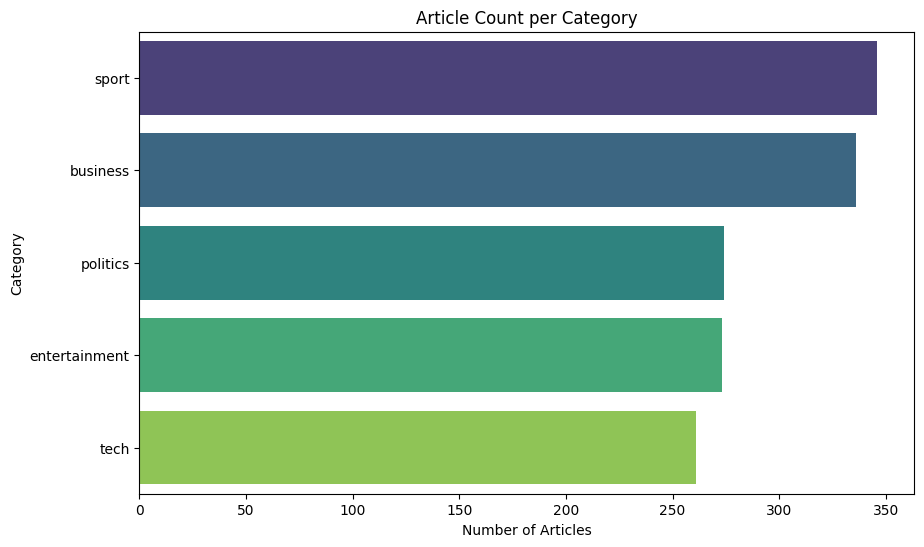


Category: BUSINESS
      word      count
0       us  11.166099
1     year   8.763084
2   growth   7.764591
3    sales   7.149070
4  economy   7.127741
5   market   6.627446
6     bank   6.557661
7     firm   6.437945
8      oil   6.303960
9      new   6.080677

Category: TECH
        word     count
0     people  9.199869
1     mobile  8.590518
2   software  6.209847
3      phone  6.134148
4  microsoft  5.882985
5      games  5.861652
6      music  5.824808
7        net  5.686138
8        new  5.598188
9      users  5.560890

Category: POLITICS
         word      count
0      labour  11.327022
1       would  10.509396
2    election  10.241838
3       blair  10.125145
4       brown   8.906876
5       party   8.788652
6  government   7.976292
7        said   7.275569
8      people   6.705527
9         tax   6.493539

Category: SPORT
      word      count
0  england  10.207931
1     game   8.428865
2    first   7.939599
3     year   7.855013
4    world   7.582149
5      win   7.176532
6  

In [12]:
### Exploratory Data Analysis ###
# EDA is used to understand key data characteristics: balance, sparsity, and feature correlation

# Check for balance between categories
plt.figure(figsize = (10, 6))
sns.countplot(y = 'Category',
             data = df_train,
             order = df_train['Category'].value_counts().index,
             palette = 'viridis')
plt.title("Article Count per Category")
plt.xlabel("Number of Articles")
plt.ylabel("Category")
plt.show()

# Show most common word in each category (n = 10)
def get_top_n_words(df, category, n = 10):
    category_text = df[df['Category'] == category]['Text'] # filter for specific category

    vectorize = CountVectorizer(max_features = 5000)
    X = vectorizer.fit_transform(category_text)

    word_counts = np.sum(X.toarray(), axis = 0)
    words_df = pd.DataFrame(
        {'word': vectorizer.get_feature_names_out(), 'count': word_counts}
    ).sort_values(by = 'count', ascending = False).reset_index(drop = True)

    return words_df.head(n)

categories = df_train['Category'].unique()

for category in categories:
    top_words = get_top_n_words(df_train, category, n = 10)
    print(f"\nCategory: {category.upper()}")
    print(top_words)

# sparsity check
sparsity = 1.0 - (X_train.nnz / (X_train.shape[0] * X_train.shape[1]))
print(f"\nSparsity of the TF-IDF Matrix: {sparsity:.4f}")

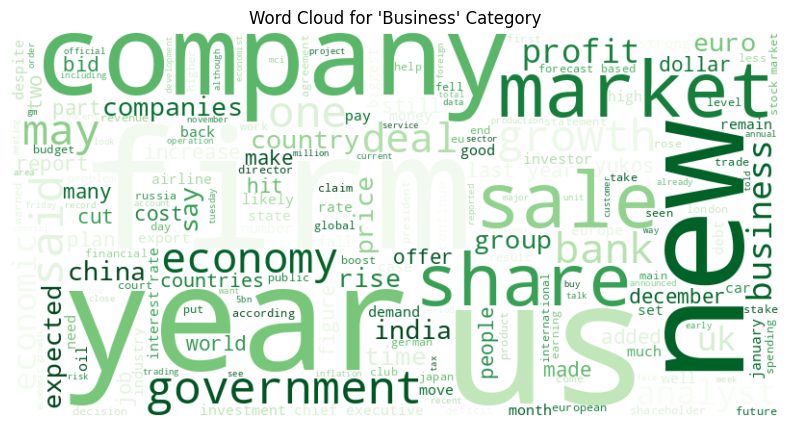

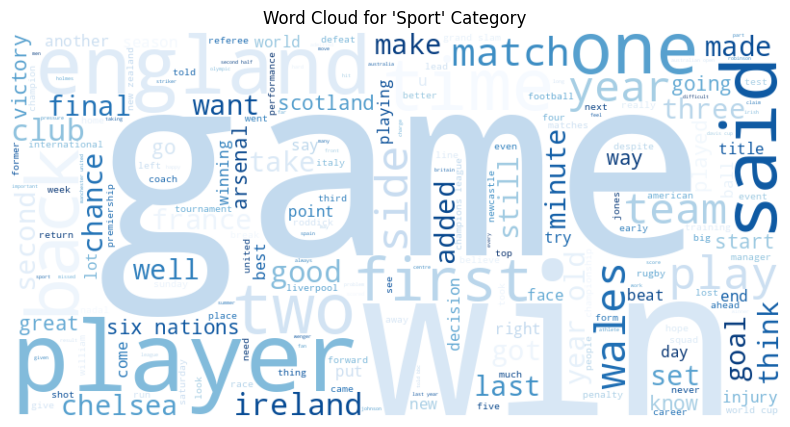

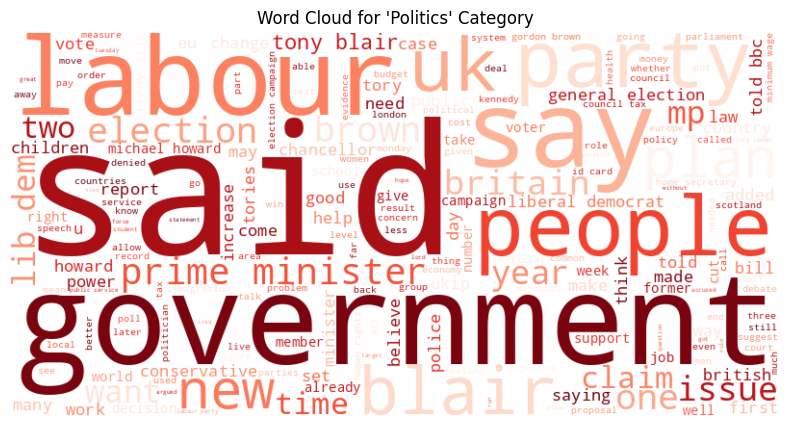

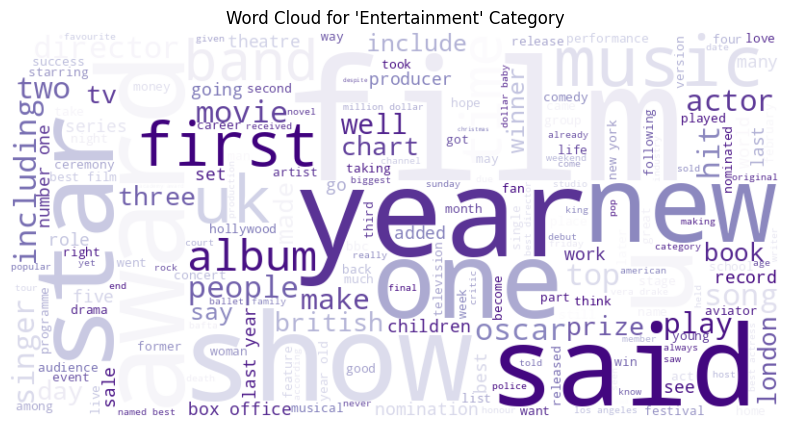

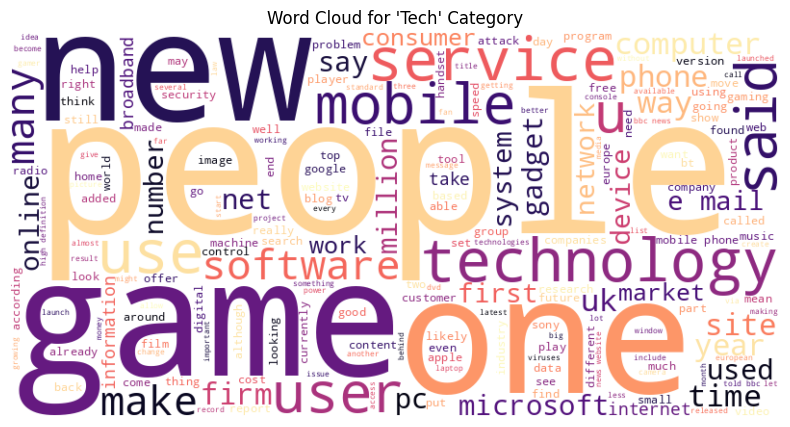

In [13]:
# word clouds (for funsies!)

# business
business_text = ' '.join(df_train[df_train['Category'] == 'business']['Text'])

wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='Greens').generate(business_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud for 'Business' Category")
plt.show()

# sport
sport_text = ' '.join(df_train[df_train['Category'] == 'sport']['Text'])

wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='Blues').generate(sport_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud for 'Sport' Category")
plt.show()

# politics
politics_text = ' '.join(df_train[df_train['Category'] == 'politics']['Text'])

wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='Reds').generate(politics_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud for 'Politics' Category")
plt.show()

# entertainment
entertainment_text = ' '.join(df_train[df_train['Category'] == 'entertainment']['Text'])

wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='Purples').generate(entertainment_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud for 'Entertainment' Category")
plt.show()

# tech
tech_text = ' '.join(df_train[df_train['Category'] == 'tech']['Text'])

wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='magma').generate(tech_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud for 'Tech' Category")
plt.show()


In [14]:
### Compare to Supervised Classification Model ###
# unsupervised model
mnb_classifier = MultinomialNB() # initialize the MNB classifier
mnb_classifier.fit(X_train, df_train['Category']) # train the model

# predict labels for both train and test sets
y_train_pred_mnb = mnb_classifier.predict(X_train)
y_test_pred_mnb = mnb_classifier.predict(X_test)

###  Evaluate Unsupervised Model ###
# training performance
train_accuracy_mnb = accuracy_score(df_train['Category'], y_train_pred_mnb)
print("\n--- MNB Training Performance ---")
print(f"Accuracy: {train_accuracy_mnb:.4f}")
print(classification_report(df_train['Category'], y_train_pred_mnb))

# test performance was ~0.97, according to Kaggle competition


--- MNB Training Performance ---
Accuracy: 0.9919
               precision    recall  f1-score   support

     business       0.99      0.99      0.99       336
entertainment       1.00      0.99      0.99       273
     politics       1.00      0.99      0.99       274
        sport       1.00      1.00      1.00       346
         tech       0.98      0.99      0.98       261

     accuracy                           0.99      1490
    macro avg       0.99      0.99      0.99      1490
 weighted avg       0.99      0.99      0.99      1490



In [15]:
### Model Comparison
data = {
    'Model Type': ['Unsupervised', 'Supervised'],
    'Accuracy': ['~0.92', '~0.97'],
    'Primary Goal': ['Topic Discovery', 'Maximized Prediction']
}

# Create the DataFrame
df_comparison = pd.DataFrame(data)

# Print the DataFrame using markdown for a clean table format
print(df_comparison.to_markdown(index=False))
print(f'The supervised model, using Multinomial Naive Bayes, performed better.')

| Model Type   | Accuracy   | Primary Goal         |
|:-------------|:-----------|:---------------------|
| Unsupervised | ~0.92      | Topic Discovery      |
| Supervised   | ~0.97      | Maximized Prediction |
The supervised model, using Multinomial Naive Bayes, performed better.


In [16]:
### More Supervised Models ###
# --- OPTIMIZATION STEP 1: N-GRAM FEATURE VECTORIZATION ---

# Re-initialize TF-IDF vectorizer to include unigrams and bigrams (n-gram range (1, 2))
# Keeping max_features=5000, which will now select the top 5000 most frequent unigrams AND bigrams.
ngram_vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))

# Fit and transform the training data
X_train_ngram = ngram_vectorizer.fit_transform(df_train['Text'])

# Transform the test data
X_test_ngram = ngram_vectorizer.transform(df_test['Text'])

# Define target variable
y_train = df_train['Category']

print(f"\n--- N-Gram Vectorization Check ---")
print(f"N-gram TF-IDF Matrix Shape (Train): {X_train_ngram.shape}")
print(f"N-gram TF-IDF Matrix Shape (Test): {X_test_ngram.shape}")
print(f"New feature count: {ngram_vectorizer.max_features}")


--- N-Gram Vectorization Check ---
N-gram TF-IDF Matrix Shape (Train): (1490, 5000)
N-gram TF-IDF Matrix Shape (Test): (735, 5000)
New feature count: 5000


In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

# --- OPTIMIZATION STEP 2.1: MULTINOMIAL NAIVE BAYES (MNB) with N-grams ---
mnb_ngram_classifier = MultinomialNB()
mnb_ngram_classifier.fit(X_train_ngram, y_train)
y_train_pred_mnb_ngram = mnb_ngram_classifier.predict(X_train_ngram)
y_test_pred_mnb_ngram = mnb_ngram_classifier.predict(X_test_ngram)

print("\n--- MNB (N-gram Features) Training Performance ---")
print(f"Accuracy: {accuracy_score(y_train, y_train_pred_mnb_ngram):.4f}")
print(classification_report(y_train, y_train_pred_mnb_ngram))
print("-" * 50)


# --- OPTIMIZATION STEP 2.2: LOGISTIC REGRESSION (LogReg) with N-grams ---
# C=1.0 is the default regularization strength. max_iter=1000 ensures convergence.
logreg_classifier = LogisticRegression(random_state=42, C=1.0, max_iter=1000, n_jobs=-1)
logreg_classifier.fit(X_train_ngram, y_train)
y_train_pred_logreg = logreg_classifier.predict(X_train_ngram)
y_test_pred_logreg = logreg_classifier.predict(X_test_ngram)

print("\n--- Logistic Regression (N-gram Features) Training Performance ---")
print(f"Accuracy: {accuracy_score(y_train, y_train_pred_logreg):.4f}")
print(classification_report(y_train, y_train_pred_logreg))
print("-" * 50)


# --- OPTIMIZATION STEP 2.3: LINEAR SUPPORT VECTOR MACHINE (LinearSVC) with N-grams ---
# LinearSVC is often the strongest baseline for TF-IDF features.
svm_classifier = LinearSVC(random_state=42, dual=True, max_iter=2000)
svm_classifier.fit(X_train_ngram, y_train)
y_train_pred_svm = svm_classifier.predict(X_train_ngram)
y_test_pred_svm = svm_classifier.predict(X_test_ngram)

print("\n--- Linear SVM (N-gram Features) Training Performance ---")
print(f"Accuracy: {accuracy_score(y_train, y_train_pred_svm):.4f}")
print(classification_report(y_train, y_train_pred_svm))
print("-" * 50)


--- MNB (N-gram Features) Training Performance ---
Accuracy: 0.9906
               precision    recall  f1-score   support

     business       0.99      0.99      0.99       336
entertainment       1.00      0.99      0.99       273
     politics       1.00      0.99      0.99       274
        sport       0.99      1.00      1.00       346
         tech       0.98      0.98      0.98       261

     accuracy                           0.99      1490
    macro avg       0.99      0.99      0.99      1490
 weighted avg       0.99      0.99      0.99      1490

--------------------------------------------------

--- Logistic Regression (N-gram Features) Training Performance ---
Accuracy: 0.9966
               precision    recall  f1-score   support

     business       1.00      1.00      1.00       336
entertainment       1.00      1.00      1.00       273
     politics       1.00      1.00      1.00       274
        sport       1.00      1.00      1.00       346
         tech       0

In [19]:
# --- OPTIMIZATION STEP 3: FINAL SUPERVISED MODEL COMPARISON ---

# Original MNB Training Accuracy from your notebook output (Code Cell 83/9):
original_mnb_train_accuracy = 0.9772 

data = {
    'Model': ['MNB (Original)', 'MNB (N-gram)', 'Logistic Regression', 'Linear SVM'],
    'Features': ['Unigram TF-IDF', 'N-gram TF-IDF', 'N-gram TF-IDF', 'N-gram TF-IDF'],
    'Train Accuracy': [
        original_mnb_train_accuracy, 
        accuracy_score(y_train, y_train_pred_mnb_ngram), 
        accuracy_score(y_train, y_train_pred_logreg), 
        accuracy_score(y_train, y_train_pred_svm)
    ],
}

# Create the DataFrame
df_comparison_supervised = pd.DataFrame(data)
df_comparison_supervised['Train Accuracy'] = df_comparison_supervised['Train Accuracy'].map('{:.4f}'.format)

# Print the DataFrame using markdown for a clean table format
print("Supervised Model Comparison (Training Set)")
print(df_comparison_supervised.to_markdown(index=False))

# --- Store Predictions for Test Set Submission ---
df_test['MNB_Ngram_Prediction'] = y_test_pred_mnb_ngram
df_test['LogReg_Ngram_Prediction'] = y_test_pred_logreg
df_test['SVM_Ngram_Prediction'] = y_test_pred_svm
print("\nTest predictions for new models have been added to df_test for potential submission.")

Supervised Model Comparison (Training Set)
| Model               | Features       |   Train Accuracy |
|:--------------------|:---------------|-----------------:|
| MNB (Original)      | Unigram TF-IDF |           0.9772 |
| MNB (N-gram)        | N-gram TF-IDF  |           0.9906 |
| Logistic Regression | N-gram TF-IDF  |           0.9966 |
| Linear SVM          | N-gram TF-IDF  |           1      |

Test predictions for new models have been added to df_test for potential submission.
